In [1]:
import sys
sys.path.append('..')

import os
import psutil
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
np.random.seed(0)

In [2]:
import matplotlib.pyplot as plt
from pylab import *
from keras.models import Sequential
from keras import optimizers
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate 
from keras.layers import Dropout, Convolution2D, AveragePooling2D
from keras.models import Model
from keras.datasets import cifar10

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from keras.preprocessing.image import ImageDataGenerator
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from custom_lib.triplet_utils import buildDataSet, build_model
from custom_lib.triplet_utils import get_batch_hard, compute_probs
from custom_lib.triplet_utils import add_top, remove_top

from art.classifiers import KerasClassifier
from art.attacks.projected_gradient_descent import ProjectedGradientDescent
from art.attacks.iterative_method import BasicIterativeMethod
from art.defences.adversarial_trainer import AdversarialTrainer
from art.attacks.fast_gradient import FastGradientMethod

from custom_lib.build_resnet import resnet_v1, new_emb

Using TensorFlow backend.


In [23]:
from custom_lib.triplet_loss import batch_hard_triplet_loss
from custom_lib.triplet_loss import batch_all_triplet_loss
from custom_lib.triplet_loss import mixed_loss
from tensorflow.contrib.losses import metric_learning

def keras_batch_hard_triplet_loss(labels, y_pred):
    labels = K.flatten(labels)
    return batch_hard_triplet_loss(labels, y_pred, margin = 0.7)

def keras_batch_all_triplet_loss(labels, y_pred):
    labels = K.flatten(labels)
    return batch_all_triplet_loss(labels, y_pred, margin = 0.7)

def keras_semi_hard_loss(labels, y_pred):
    labels = K.flatten(labels)
    return metric_learning.triplet_semihard_loss(labels, y_pred, margin=0.7)

def keras_mixed_loss(labels, y_pred):
    labels = K.flatten(labels)
    return mixed_loss(labels, y_pred, margin = 0.7, ratio=0.5)

In [4]:
def restrict_cpu():
    p = psutil.Process()

    for i in p.threads():
        temp = psutil.Process(i.id)

        temp.cpu_affinity([i+4 for i in range(4)])

In [5]:
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

val_train = to_categorical(y_train, 10)
val_test = to_categorical(y_test, 10)

In [6]:
learning_rate = 5e-6
batch_size=64
epochs=10

nb_classes = 10
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
in_shape = input_shape

#dataset_train, dataset_test, x_train_origin, y_train_origin, x_test_origin, y_test_origin = buildDataSet(cifar=True)

In [7]:
'''
temp = resnet_v1(input_shape)

temp.load_weights("saved_models/resnet.h5")
temp.compile(optimizer=Adam(lr=5e-4), loss='categorical_crossentropy', metrics=["accuracy"])

base_model = new_emb(input_shape)

for i, layer in enumerate(base_model.layers):
    layer.set_weights(temp.layers[i].get_weights())
    
base_model.save_weights("saved_models/new_base.h5")
'''
None

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


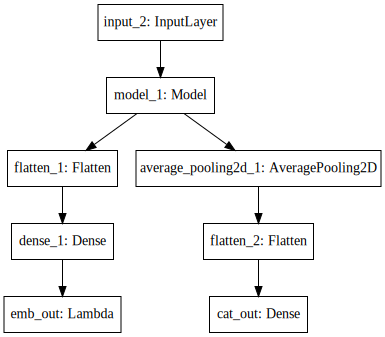

In [8]:
# -------------------- Base Model --------------------------

base_model = new_emb(input_shape)
base_model.load_weights("saved_models/new_base.h5")

base_in = Input(shape=in_shape)
base_out = base_model(base_in)

# -------------------- Emb Model ---------------------------

emb_branch = Flatten()(base_out)
emb_branch = Dense(128, activation='relu', kernel_initializer='he_normal')(emb_branch)
emb_branch = Lambda(lambda t: K.l2_normalize(t,axis=-1), name="emb_out")(emb_branch)
                                                  
# -------------------- Categorical Model -------------------

cat_branch = AveragePooling2D(pool_size=8)(base_out)
cat_branch = Flatten()(cat_branch)
cat_branch = Dense(10, activation='softmax', name="cat_out")(cat_branch)

# -------------------- Compile -----------------------------

model = Model(inputs=base_in, 
              outputs=[emb_branch, cat_branch], 
              name="fullnet")

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
#model.load_weights("saved_models/adv_model_2_1.h5")

In [24]:
losses = {
    "emb_out": keras_mixed_loss,
    "cat_out": "categorical_crossentropy",
}

lossWeights = {"emb_out": 0.65, "cat_out": 0.35}

model.compile(optimizer=Adam(lr=5e-5), loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

In [13]:
b_in = Input(shape=in_shape)
b_out = model(b_in)[1]

adv_model = Model(inputs=b_in, outputs=b_out)
adv_model.compile(loss="categorical_crossentropy", optimizer=Adam(5e-4), metrics=["accuracy"])

In [12]:
model.fit(x_train, [y_train, val_train],
          validation_data=(x_test, [y_test, val_test]),
          epochs=3, 
          batch_size=32,
          verbose=1)

In [13]:
#import art.attacks.projected_gradient_descent

#from importlib import reload
#reload(art.attacks.projected_gradient_descent)

In [14]:
art_model = KerasClassifier(clip_values=(0, 1.), model=adv_model, use_logits=False)
attack = ProjectedGradientDescent(art_model, norm=2, eps=8, random_eps=True, eps_step=0.1, max_iter=5, batch_size=16)

adv_test = attack.generate(x_test[:10])

restrict_cpu()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [15]:
eval_loss = adv_model.evaluate(x_test, val_test, verbose=0)

print("Base images:")
for i, name in enumerate(adv_model.metrics_names):
    print(name, eval_loss[i])
    
losses = []
accs = []


for i in range(0, 8000, 32):
    adv_test = attack.generate(x_test[i:i+32])
    eval_loss = adv_model.evaluate(adv_test, val_test[i:i+32], verbose=0)
    losses.append(eval_loss[0])
    accs.append(eval_loss[1])

print("\nAdv images:")
print('loss', np.mean(losses))
print('acc', np.mean(accs))

Base images:
loss 0.44513707695007326
acc 0.8979

Adv images:
loss 13.068375983357429
acc 0.097625


In [25]:
def batch_generator(X, Y, VAL, batch_size = 64):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
            # it might be a good idea to shuffle your data before each epoch
            np.random.shuffle(indices) 
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    adv_x = X[batch]
                    adv_x[:48] = attack.generate(adv_x[:48])
                    yield adv_x, [Y[batch], VAL[batch]]
                    batch=[]

train_generator = batch_generator(x_train, y_train, val_train, batch_size = 64)

In [26]:
#K.set_value(model.optimizer.lr, 1e-5)

In [27]:
# Hyper parameters
evaluate_every = 250 # interval for evaluating on one-shot tasks
n_iter = 10_000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
n_iteration=0

loss_list = []
emb_vals = []
cat_vals = []

print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

for i in range(1, n_iter+1):
    
    batch = train_generator.__next__()
    
    loss = model.train_on_batch(batch[0], batch[1])
    
    emb_vals.append(loss[0])
    cat_vals.append(loss[1])
    
    n_iteration += 1
    
    if i % 4000 == 0:
        K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr)/2.0)
    
    if i % evaluate_every == 0:
        ploss = (np.mean(emb_vals), np.mean(cat_vals))
        loss_list.append(ploss)
        emb_vals = []
        cat_vals = []
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,ploss,n_iteration))

Starting training process!
-------------------------------------

 ------------- 

[250] Time for 250 iterations: 2.3 mins, Train Loss: (0.9581433, 0.7001682)

 ------------- 

[500] Time for 500 iterations: 4.3 mins, Train Loss: (0.9592888, 0.7001564)

 ------------- 

[750] Time for 750 iterations: 6.3 mins, Train Loss: (0.97203356, 0.70015186)

 ------------- 

[1000] Time for 1000 iterations: 8.3 mins, Train Loss: (0.9653899, 0.70017123)

 ------------- 

[1250] Time for 1250 iterations: 10.2 mins, Train Loss: (0.9628843, 0.70017546)

 ------------- 

[1500] Time for 1500 iterations: 12.2 mins, Train Loss: (0.97539115, 0.70016575)

 ------------- 

[1750] Time for 1750 iterations: 14.1 mins, Train Loss: (0.9638762, 0.7001509)

 ------------- 

[2000] Time for 2000 iterations: 16.1 mins, Train Loss: (0.96149814, 0.700145)

 ------------- 

[2250] Time for 2250 iterations: 18.0 mins, Train Loss: (0.98073804, 0.7001445)

 ------------- 

[2500] Time for 2500 iterations: 20.0 mins, Tra

KeyboardInterrupt: 

In [28]:
eval_loss = adv_model.evaluate(x_test, val_test, verbose=0)

print("Base images:")
for i, name in enumerate(adv_model.metrics_names):
    print(name, eval_loss[i])
    
losses = []
accs = []


for i in range(0, 8000, 32):
    adv_test = attack.generate(x_test[i:i+32])
    eval_loss = adv_model.evaluate(adv_test, val_test[i:i+32], verbose=0)
    losses.append(eval_loss[0])
    accs.append(eval_loss[1])

print("\nAdv images:")
print('loss', np.mean(losses))
print('acc', np.mean(accs))

Base images:
loss 0.5470993059158326
acc 0.8509

Adv images:
loss 1.9823062419891357
acc 0.335625


In [21]:
ls

comparative_adv.ipynb  model.png             test_advs.ipynb
Model_1.ipynb          resnet_tests.ipynb    train_resnet.py
Model_2.ipynb          resnet_triplet.ipynb
Model_3.ipynb          saved_models/


In [20]:
model.save_weights("saved_models/adv_model_2_1.h5")

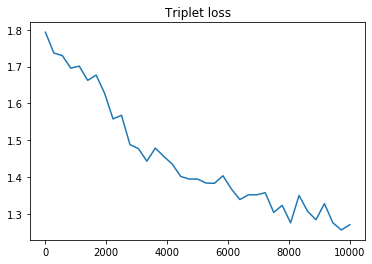

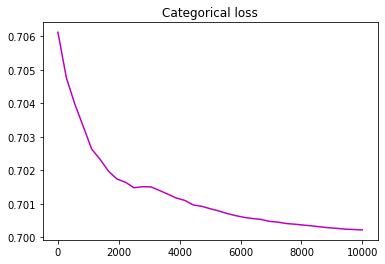

In [24]:
y_axis = [l[0] for l in loss_list[3:]]
x_axis = np.linspace(0, 10_000, len(y_axis)).round()
plt.plot(x_axis, y_axis)
plt.title("Triplet loss")
plt.show()

y_axis = [l[1] for l in loss_list[3:]]
x_axis = np.linspace(0, 10_000, len(y_axis)).round()
plt.plot(x_axis, y_axis, 'm')
plt.title("Categorical loss")
plt.show()

In [17]:
# Hyper parameters

#K.set_value(adv_model.optimizer.lr, 1e-8)

evaluate_every = 200 # interval for evaluating on one-shot tasks
n_iter = 15000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
n_iteration=0

loss_list = []
emb_vals = []
cat_vals = []

print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

for i in range(1, n_iter+1):
    
    batch = train_generator.__next__()
    
    loss = adv_model.train_on_batch(batch[0], batch[1])
    
    emb_vals.append(loss[0])
    cat_vals.append(loss[1])
    
    n_iteration += 1
    
    if i % 5000 == 0:
        K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr)/5.0)
    
    if i % evaluate_every == 0:
        ploss = (np.mean(emb_vals), np.mean(cat_vals))
        loss_list.append(ploss)
        emb_vals = []
        cat_vals = []
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,ploss,n_iteration))

Starting training process!
-------------------------------------

 ------------- 

[200] Time for 200 iterations: 0.8 mins, Train Loss: (1.581496, 0.59828126)

 ------------- 

[400] Time for 400 iterations: 1.5 mins, Train Loss: (1.3955872, 0.5590625)

 ------------- 

[600] Time for 600 iterations: 2.3 mins, Train Loss: (1.3457147, 0.5750781)

 ------------- 

[800] Time for 800 iterations: 3.0 mins, Train Loss: (1.3410496, 0.5733594)

 ------------- 

[1000] Time for 1000 iterations: 3.8 mins, Train Loss: (1.2519614, 0.60117185)

 ------------- 

[1200] Time for 1200 iterations: 4.5 mins, Train Loss: (1.2337501, 0.6077344)

 ------------- 

[1400] Time for 1400 iterations: 5.3 mins, Train Loss: (1.2415715, 0.60398436)

 ------------- 

[1600] Time for 1600 iterations: 6.0 mins, Train Loss: (1.2121341, 0.6152344)

 ------------- 

[1800] Time for 1800 iterations: 6.8 mins, Train Loss: (1.189574, 0.6180469)

 ------------- 

[2000] Time for 2000 iterations: 7.6 mins, Train Loss: (1.18

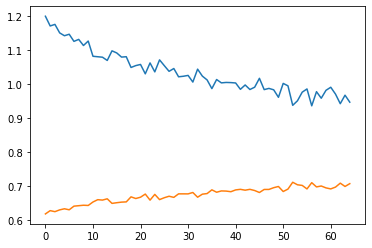

In [21]:
x1 = [l[0] for l in loss_list[10:]]
x2 = [l[1] for l in loss_list[10:]]
plt.plot(x1)
plt.plot(x2)
plt.show()

In [18]:
eval_loss = adv_model.evaluate(x_test, val_test, verbose=1)

for i, name in enumerate(adv_model.metrics_names):
    print(name, eval_loss[i])
    
accs = []

for i in range(0, 8000, 32):
    adv_test = attack.generate(x_test[i:i+32])
    eval_loss = adv_model.evaluate(adv_test, val_test[i:i+32], verbose=0)
    accs.append(eval_loss[1])

print("Adv images:")
print(np.mean(accs))

10000/10000 [==============================] - 2s 226us/step
loss 0.7007946513175964
acc 0.8169
Adv images:
0.45025


In [ ]:
dist_matrix = np.zeros(shape=(10, 10))

for i in range(10):
    start = time.time()
    outs_1 = pen_output([dataset_train[i]])[0]
    print(i)
    for j in range(10):
        outs_2 = pen_output([attack.generate(dataset_train[j][:2000])])[0]
        norms = []
        for k in range(1000):
            norms.append(norm(outs_1[
                np.random.randint(0, 5000)] - outs_2[
                np.random.randint(0, 2000)]))
        dist_matrix[i][j] = np.mean(norms)
    end = time.time()
    print(end-start)

print(dist_matrix.round(3))

plt.imshow(dist_matrix / dist_matrix.max(), cmap="Greys")
plt.show()

In [57]:
eval_loss

[2.229891538619995, 0.34375]

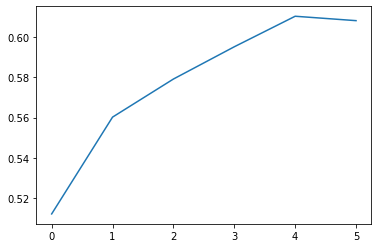

In [17]:
#x1 = [l[0] for l in loss_list]
x2 = [l[1] for l in loss_list]
#plt.plot(x1)
plt.plot(x2)
plt.show()

In [20]:
eval_loss = adv_model.evaluate(x_test, val_test, verbose=0)

print("Base images:")
for i, name in enumerate(model.metrics_names):
    print("  ", name, eval_loss[i])
    
accs = []

for i in range(0, 3000, 32):
    adv_test = attack.generate(x_test[i:i+32])
    eval_loss = adv_model.evaluate(adv_test, val_test[i:i+32], verbose=0)
    accs.append(eval_loss[1])

print("Adv images:")
np.mean(accs)

Base images:
   loss 0.7759025994300842
   emb_out_loss 0.7952


IndexError: list index out of range

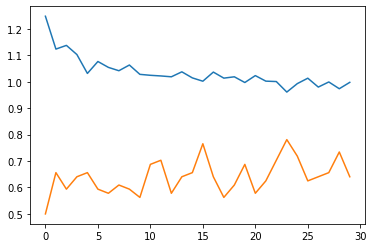

In [18]:
x1 = [l[1] for l in loss_list]
x2 = [l[4] for l in loss_list]
plt.plot(x1)
plt.plot(x2)
plt.show()

In [17]:
eval_loss = model.evaluate(x_test, [y_test, val_test], verbose=0)

print("Base images:")
for i, name in enumerate(model.metrics_names):
    print("  ", name, eval_loss[i])
    
adv_test = attack.generate(x_test)
eval_loss = model.evaluate(adv_test, [y_test, val_test], verbose=0)

print("Adv images:")
for i, name in enumerate(model.metrics_names):
    print("  ", name, eval_loss[i])

Base images:
   loss 0.8174479370117187
   emb_out_loss 0.9238985250473023
   cat_out_loss 0.612490875196457
   emb_out_acc 0.0
   cat_out_acc 0.7954
Adv images:
   loss 1.4589559022903442
   emb_out_loss 0.9801555199623108
   cat_out_loss 1.504821113204956
   emb_out_acc 0.0
   cat_out_acc 0.4236


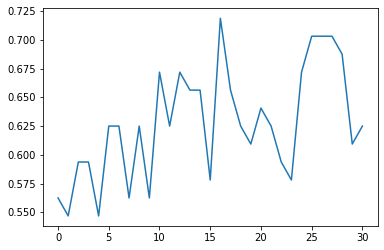

In [18]:
x1 = [l[1] for l in loss_list]
plt.plot(x1)
plt.show()

In [19]:
eval_loss = adv_model.evaluate(x_test, val_test, verbose=0)

print("Base images:")
for i, name in enumerate(adv_model.metrics_names):
    print("  ", name, eval_loss[i])
    
adv_test = attack.generate(x_test)
eval_loss = adv_model.evaluate(adv_test, val_test, verbose=0)

print("Adv images:")
for i, name in enumerate(adv_model.metrics_names):
    print("  ", name, eval_loss[i])

Base images:
   loss 0.702584770488739
   acc 0.8136
Adv images:
   loss 1.6653723711013795
   acc 0.4161
